### Importing Necessary Datasets

In [1]:
import pandas as pd
import datetime
import numpy as np
import json
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import haversine_distances
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.linear_model import ElasticNetCV
import xgboost

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU
from tensorflow.keras.layers import Dropout


### Importing Data

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data?select=train.csv

In [2]:
df = pd.read_csv('taxifare.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df.shape

(120000, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


### Feature Engineering

##### Converting pickup datettime field to date time format from object format

In [5]:
pd.to_datetime(df['pickup_datetime'])

0        2010-04-19 08:17:56+00:00
1        2010-04-17 15:43:53+00:00
2        2010-04-17 11:23:26+00:00
3        2010-04-11 21:25:03+00:00
4        2010-04-17 02:19:01+00:00
                    ...           
119995   2010-04-18 14:33:03+00:00
119996   2010-04-23 10:27:48+00:00
119997   2010-04-18 18:50:40+00:00
119998   2010-04-13 08:14:44+00:00
119999   2010-04-17 16:00:14+00:00
Name: pickup_datetime, Length: 120000, dtype: datetime64[ns, UTC]

##### Since datatime is in UTC time, we are turning it to EST

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])-datetime.timedelta(hours=4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 7.3 MB


##### Breaking pickup_datetime field into Year, Month, Day, Hours and Minutes

In [8]:
df['Year'] = df['pickup_datetime'].dt.year
df['Month'] = df['pickup_datetime'].dt.month
df['Day'] = df['pickup_datetime'].dt.day
df['Hours'] = df['pickup_datetime'].dt.hour
df['Minutes'] = df['pickup_datetime'].dt.minute

In [9]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Hours,Minutes
0,2010-04-19 04:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17
1,2010-04-17 11:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43
2,2010-04-17 07:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23
3,2010-04-11 17:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25
4,2010-04-16 22:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19


##### Classifying Morning Night

In [10]:
df['MorningNight']=np.where(df['Hours']<12,0,1)

In [11]:
df.drop('pickup_datetime',axis=1,inplace=True)

In [12]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Day,Hours,Minutes,MorningNight
0,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2010,4,19,4,17,0
1,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,2010,4,17,11,43,0
2,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,2010,4,17,7,23,0
3,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,2010,4,11,17,25,1
4,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2010,4,16,22,19,1


##### Calculating Haversine Distances using Latitude and Longitude values

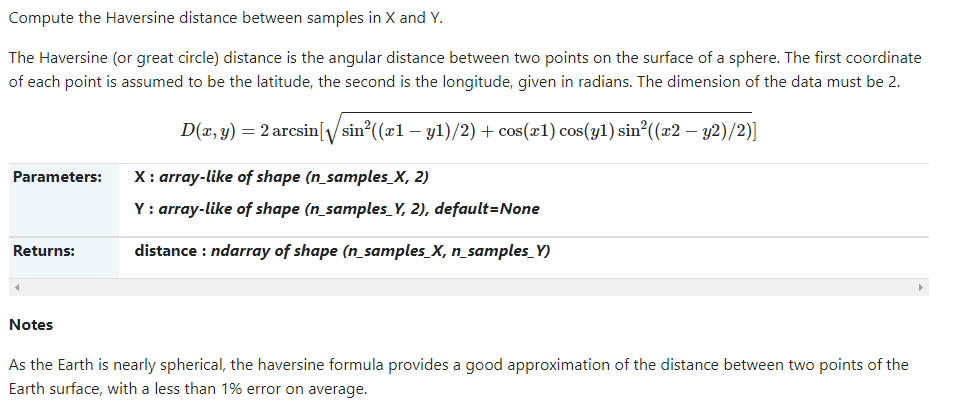

In [13]:
def haversine(df):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat1= np.radians(df["pickup_latitude"])
    lat2 = np.radians(df["dropoff_latitude"])
    #### Based on the formula  x1=drop_lat,x2=dropoff_long 
    dlat = np.radians(df['dropoff_latitude']-df["pickup_latitude"])
    dlong = np.radians(df["dropoff_longitude"]-df["pickup_longitude"])
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [14]:
df['Total_Distance'] = haversine(df)

In [15]:
df.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"],axis=1,inplace=True)

In [16]:
df.head()

,fare_amount,fare_class,passenger_count,Year,Month,Day,Hours,Minutes,MorningNight,Total_Distance
0,6.5,0,1,2010,4,19,4,17,0,2.126312
1,6.9,0,1,2010,4,17,11,43,0,1.392307
2,10.1,1,2,2010,4,17,7,23,0,3.326763
3,8.9,0,1,2010,4,11,17,25,1,1.864129
4,19.7,1,1,2010,4,16,22,19,1,7.231321


### Regression Model

#### Exporting Data to CSV

In [17]:
X = df.iloc[:,1:]
y = df.iloc[:,0]
X.head()

,fare_class,passenger_count,Year,Month,Day,Hours,Minutes,MorningNight,Total_Distance
0,0,1,2010,4,19,4,17,0,2.126312
1,0,1,2010,4,17,11,43,0,1.392307
2,1,2,2010,4,17,7,23,0,3.326763
3,0,1,2010,4,11,17,25,1,1.864129
4,1,1,2010,4,16,22,19,1,7.231321


In [18]:
y.head()

0     6.5
1     6.9
2    10.1
3     8.9
4    19.7
Name: fare_amount, dtype: float64

In [19]:
df.to_csv('final_data.csv')

#### Feature Selection using Feature Importances

In [20]:
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

#### Ploting graph of feature importances for better visualization

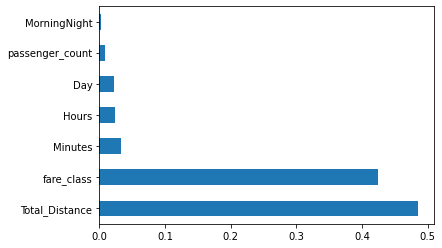

In [21]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.show()

#### Train Test Split

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=100)

#### Using XGBoost Regressor

In [23]:
xgb_regressor = xgboost.XGBRegressor()
xgb_regressor.fit(X_train,y_train)
y_pred = xgb_regressor.predict(X_test)

#### Model Evaluation

C:\Users\D100793\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


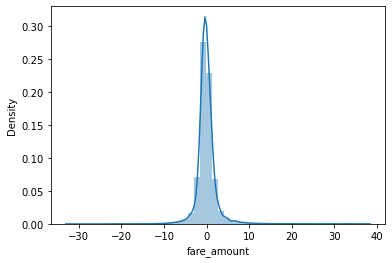

In [24]:
sns.distplot(y_test-y_pred)

test values and pred values delta is showing Gaussian distribution, which may mean the model is pretty good

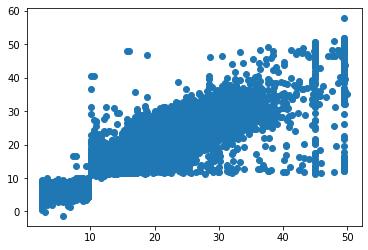

In [25]:
plt.scatter(y_test,y_pred)

most of test values and pred values show a certain level of correlation

In [26]:
print('R square:', np.sqrt(metrics.r2_score(y_test, y_pred)))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R square: 0.9400762643333571
MAE: 1.4025255433477628
MSE: 6.6505615409924435
RMSE: 2.578868267475569


Model shows a very good R Square

#### Hyperparameter Tuning of XGB Regressor

In [27]:
# Number of trees in Xgboost
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Various learning rate parameters
learning_rate = ['0.05','0.1', '0.2','0.3','0.5','0.6']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
#Subssample parameter values
subsample=[0.7,0.6,0.8]
# Minimum child weight parameters
min_child_weight=[3,4,5,6,7]

##### Create the random grid

In [28]:
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.05', '0.1', '0.2', '0.3', '0.5', '0.6'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_weight': [3, 4, 5, 6, 7]}


In [29]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
regressor=xgboost.XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
xg_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter =5, cv = 5, verbose=2, random_state=42, n_jobs = -1)
xg_random.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:  9.3min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 12.2min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=5, n_jobs=-1,
                   para

In [30]:
xg_random.best_params_

{'subsample': 0.8,
 'n_estimators': 1100,
 'min_child_weight': 6,
 'max_depth': 25,
 'learning_rate': '0.05'}

#### Model Evaluation

In [31]:
y_pred = xg_random.predict(X_test)

C:\Users\D100793\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


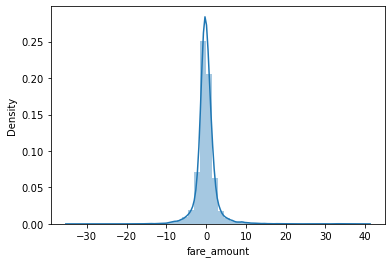

In [32]:
sns.distplot(y_test-y_pred)

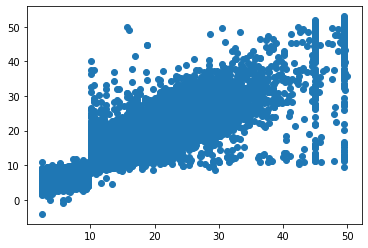

In [33]:
plt.scatter(y_test,y_pred)

In [34]:
print('R square:', np.sqrt(metrics.r2_score(y_test, y_pred)))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R square: 0.9262621090306772
MAE: 1.58401330341383
MSE: 8.125437017099834
RMSE: 2.8505152195874754


#### Regresion using ANN

In [35]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer ='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu'))
NN_model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu'))
NN_model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer = 'normal',activation = 'linear'))

# Compile the network :
NN_model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['mean_absolute_error'])
NN_model.summary()

# Fitting the ANN to the Training set
model_history = NN_model.fit(X_train, y_train,validation_split = 0.33, batch_size = 10, epochs = 20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
5628/5628 [==============================] - 8s 1ms/step - loss: 2.2575 - mean_absolute_error: 2.2575 - v

#### Model Evaluation

C:\Users\D100793\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


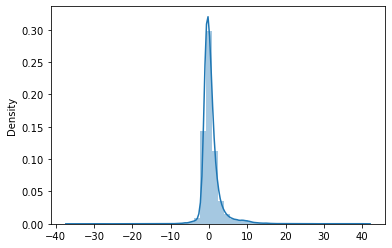

In [36]:
prediction = NN_model.predict(X_test)
sns.distplot(y_test.values.reshape(-1,1)-prediction)

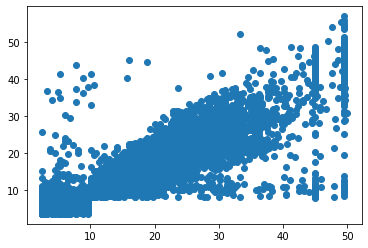

In [37]:
plt.scatter(y_test,prediction)

In [38]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1.5189440008295907
MSE: 9.31976751904814
RMSE: 3.0528294284234323
